In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
initial_snippet = np.fromfile('/home/mwootten/school/research/average.raw32', dtype=np.dtype('i4'), count=20000)

In [4]:
initial_snippet

array([445, 442, 461, ..., 180, 221, 494], dtype=int32)

In [2]:
diffs = np.diff(initial_snippet)
pd.DataFrame(diffs).describe()

,0
count,19999.000000
mean,0.002450
std,196.944522
min,-3098.000000
25%,-75.000000
50%,-1.000000
75%,79.000000
max,2924.000000


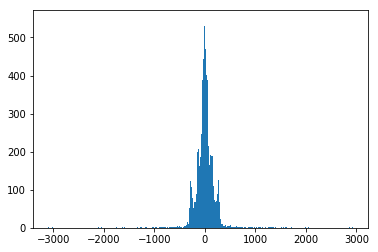

In [15]:
plt.hist(diffs, bins=1000)
plt.show()

In [18]:
len(diffs[abs(diffs) > 100])

8679

In [19]:
len(diffs[abs(diffs) > 200])

3799

Taken from [Stack Overflow](https://stackoverflow.com/questions/22179119/normality-test-of-a-distribution-in-python#22179525)

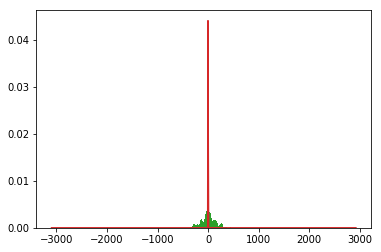

In [5]:
import matplotlib.mlab as mlab
import math

n, bins, patches = plt.hist(diffs, 1000, normed=1)
mu = np.mean(diffs)
sigma = np.std(diffs)
plt.plot(bins, mlab.normpdf(bins, mu, sigma / math.sqrt(20000)))
plt.show()

Okay, so these don't look like they're normally distributed. Back to guess and check.

In [23]:
len(diffs[abs(diffs) > 300])

879

In [24]:
len(diffs[abs(diffs) > 400])

515

In [25]:
len(diffs[abs(diffs) > 500])

386

In [31]:
len(diffs[abs(diffs) > 2000])

10

That seems like a reasonable cutoff to me - it's down to 0.05% of the samples. It's no longer that much worse than the 5 from before.

In [32]:
abs(diffs) > 2000

array([False, False, False, ..., False, False, False], dtype=bool)

Code from https://stackoverflow.com/questions/21448225/getting-indices-of-true-values-in-a-boolean-list#21448251

In [35]:
trigger_times = [i for i, x in enumerate(abs(diffs) > 2000) if x]

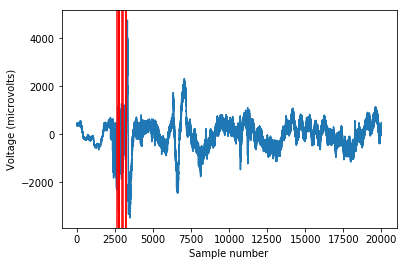

In [40]:
x = np.arange(0, 20000, 1)
y = initial_snippet
plt.plot(x, y)
for t in trigger_times:
    plt.axvline(x=t, color="red")
plt.xlabel('Sample number')
plt.ylabel('Voltage (microvolts)')
plt.show()

That doesn't look encouraging - it looks like a more nuanced approach will be necessary than simply looking at the sample-to-sample change.